In [1]:
import pandas as pd
import numpy as np
import glob
import os

from scipy.stats import norm
import scipy.signal
import scipy.signal.windows  
scipy.signal.gaussian = scipy.signal.windows.gaussian
import pymc as pm
import arviz as az
from metadpy.utils import trials2counts
from metadpy.mle import fit_metad, metad
from collections import Counter
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load Data

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None)

In [3]:
csv_dir = "data/"
csv_files = glob.glob(os.path.join(csv_dir, "*.csv"))

In [4]:
dfs = [pd.read_csv(f) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

In [5]:
df['soa_offset'] = round((df['soa_ms'] - df['threshold']) / 7)

In [6]:
df.head()

,subj,trial,soa_ms,catch_trial,detect_yn,confidence,threshold,soa_offset
0,Alex,0,69.575979,False,False,1,49.0,3.0
1,Alex,1,55.660783,False,True,3,49.0,1.0
2,Alex,2,55.660783,False,True,4,49.0,1.0
3,Alex,3,34.787990,False,False,2,49.0,-2.0
4,Alex,4,76.533577,False,True,4,49.0,4.0


## Calculate d' and meta-d' Scores

In [7]:

def counts_8(trials, conf_col="confidence"):
    """
    Return nR_S1, nR_S2 as 8-element int lists, already +1 padded.
    Order follows Maniscalco & Lau:    R=S1, conf K..1 | R=S2, conf 1..K
    """
    # initialise every cell with 1  (pseudo-count)
    nR_S1 = [1]*8
    nR_S2 = [1]*8

    for _, row in trials.iterrows():
        s       = row.signal          # 0 or 1
        respS2  = row.detect_yn       # 0=“S1”  1=“S2”
        c       = int(row[conf_col])  # 1..4
        if respS2 == 0:               # responded “S1”
            idx = 4-c                 # conf 4→0, 3→1, 2→2, 1→3
        else:                         # responded “S2”
            idx = 3+c                 # conf 1→4, 2→5, 3→6, 4→7
        if s == 0:
            nR_S1[idx] += 1
        else:
            nR_S2[idx] += 1
    return nR_S1, nR_S2

In [8]:
df["signal"]  = (~df["catch_trial"]).astype(int)
df["resp"]    = df["detect_yn"].astype(int)
df["correct"] = (df["resp"] == df["signal"]).astype(int)

rows = []
for (subj, soa), grp in df.groupby(["subj","soa_offset"]):
    # -------- d′ ----------
    H  = grp.query("signal==1 & resp==1").shape[0]
    FA = grp.query("signal==0 & resp==1").shape[0]
    n_sig   = grp.query("signal==1").shape[0]
    n_noise = grp.query("signal==0").shape[0]
    dprime  = norm.ppf((H+0.5)/(n_sig+1)) - norm.ppf((FA+0.5)/(n_noise+1))

    # -------- meta-d′ ----------
    try:
        # Pass the group DataFrame directly
        meta = metad(data=grp,  # Pass the DataFrame for the current group
                    stimuli="signal",
                    accuracy="correct",
                    confidence="confidence",
                    nRatings=4,
                    padding=True,  # Let metadpy handle padding
                    verbose=0
                    )
        meta_d = float(meta.loc[0, "meta_d"])
    except Exception as e:
        meta_d = np.nan

    rows.append(dict(subj=subj, soa_offset=soa,
                     dprime=dprime, meta_dprime=meta_d))

summary = pd.DataFrame(rows)

c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: divide by zero encountered in scalar divide
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))
c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: invalid value encountered in scalar multiply
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))
c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\metadpy\mle.py:746: RuntimeWarning: invalid value encountered in scalar divide
  guess.extend(list(t2c1 - (meta_d1 * (t1c1 / d1))))


In [9]:
summary.head(5)

,subj,soa_offset,dprime,meta_dprime
0,Alex,-4.0,-0.607958,-0.119403
1,Alex,-3.0,-0.070151,NaN
2,Alex,-2.0,0.823700,-0.149928
3,Alex,-1.0,0.652647,NaN
4,Alex,-0.0,0.823700,NaN


## Fit Linear Hierarchical Bayesian Models to d' and meta-d' Separately

In [10]:
d_data = summary[['subj', 'soa_offset', 'dprime']].dropna().copy()
d_data['subj_idx'] = d_data['subj'].astype('category').cat.codes
d_data['soa_std'] = (d_data['soa_offset'] - d_data['soa_offset'].mean()) / d_data['soa_offset'].std()
pm.traceplot.progressbar = True

subj_names = d_data['subj'].astype('category').cat.categories.tolist()

with pm.Model(coords={"subj": subj_names}) as dprime_model:
    mu_a    = pm.Normal('mu_a',    mu=0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1)
    mu_b    = pm.Normal('mu_b',    mu=0, sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', sigma=1)

    # now dims="subj" is valid
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims="subj")
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, dims="subj")

    soa = pm.Data('soa_std',  d_data['soa_std'].values)
    si  = pm.Data('subj_idx', d_data['subj_idx'].values)

    # use the DataContainer for both index and covariate
    mu = a[si] + b[si] * soa
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    pm.Normal('obs', mu=mu, sigma=sigma_obs, observed=d_data['dprime'].values)
    print("Beginning sampling...\n")
    trace_d = pm.sample(
        1000, 
        tune=1000,
        chains=2,
        cores=1,
        target_accept=0.9,
        init="adapt_diag",
        progressbar=True
    )

c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\pymc\data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Beginning sampling...



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_obs]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


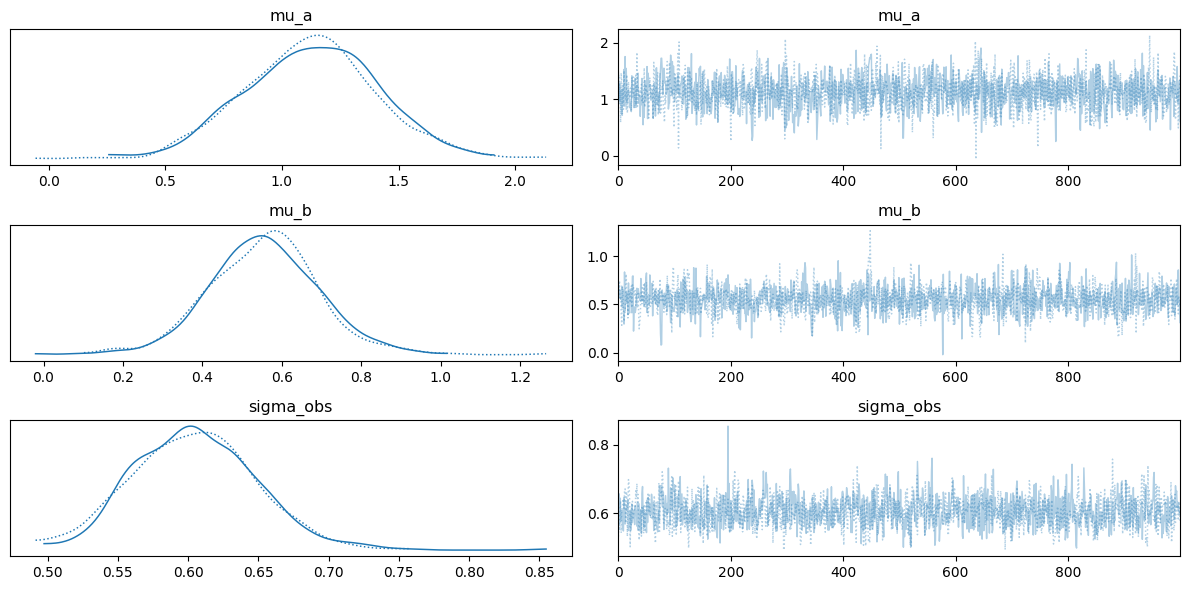

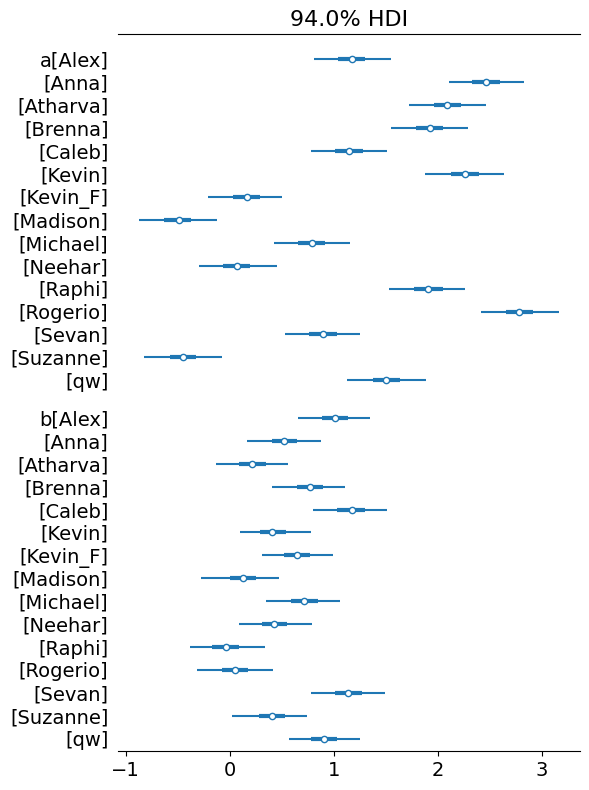

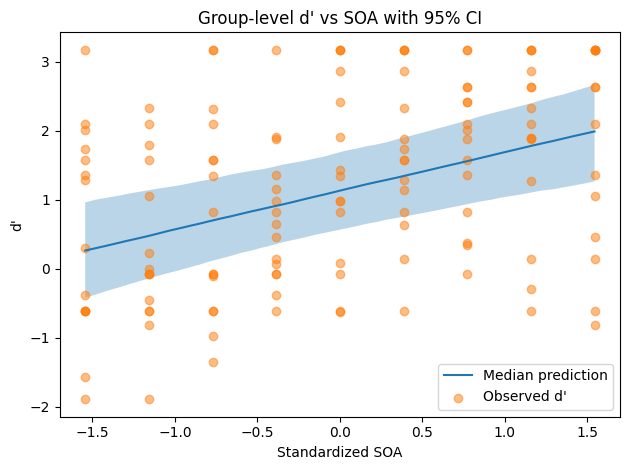

In [11]:
az.plot_trace(trace_d, var_names=['mu_a', 'mu_b', 'sigma_obs'])
plt.tight_layout()
plt.show()

# 2. Forest plot for subject-level effects
az.plot_forest(trace_d, var_names=['a', 'b'], combined=True)
plt.tight_layout()
plt.show()

# 3. Group-level regression credible bands
posterior = trace_d.posterior
mu_a_samples = posterior['mu_a'].stack(samples=("chain", "draw")).values
mu_b_samples = posterior['mu_b'].stack(samples=("chain", "draw")).values

soa_std_vals = np.linspace(d_data['soa_std'].min(), d_data['soa_std'].max(), 50)
preds = np.array([mu_a_samples + mu_b_samples * x for x in soa_std_vals])

median_pred = np.median(preds, axis=1)
lower_pred = np.percentile(preds, 2.5, axis=1)
upper_pred = np.percentile(preds, 97.5, axis=1)

plt.figure()
plt.fill_between(soa_std_vals, lower_pred, upper_pred, alpha=0.3)
plt.plot(soa_std_vals, median_pred, label='Median prediction')
plt.scatter(d_data['soa_std'], d_data['dprime'], alpha=0.5, label="Observed d'")
plt.xlabel('Standardized SOA')
plt.ylabel("d'")
plt.title("Group-level d' vs SOA with 95% CI")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
metad_data = summary[['subj', 'soa_offset', 'meta_dprime']].dropna().copy()
metad_data['subj_idx'] = metad_data['subj'].astype('category').cat.codes
metad_data['soa_std'] = (metad_data['soa_offset'] - metad_data['soa_offset'].mean()) / metad_data['soa_offset'].std()
pm.traceplot.progressbar = True

subj_names = metad_data['subj'].astype('category').cat.categories.tolist()

with pm.Model(coords={"subj": subj_names}) as meta_dprime_model:
    mu_a    = pm.Normal('mu_a',    mu=0, sigma=1)
    sigma_a = pm.HalfNormal('sigma_a', sigma=1)
    mu_b    = pm.Normal('mu_b',    mu=0, sigma=1)
    sigma_b = pm.HalfNormal('sigma_b', sigma=1)

    # now dims="subj" is valid
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, dims="subj")
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, dims="subj")

    soa = pm.Data('soa_std',  metad_data['soa_std'].values)
    si  = pm.Data('subj_idx', metad_data['subj_idx'].values)

    # use the DataContainer for both index and covariate
    mu = a[si] + b[si] * soa
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    pm.Normal('obs', mu=mu, sigma=sigma_obs, observed=metad_data['meta_dprime'].values)
    print("Beginning sampling...\n")
    trace_metad = pm.sample(
        1000, 
        tune=1000,
        chains=2,
        cores=1,
        target_accept=0.9,
        init="adapt_diag",
        progressbar=True
    )

c:\Users\Owner\Anaconda3\envs\cognition\lib\site-packages\pymc\data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Beginning sampling...



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a, b, sigma_obs]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 22 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


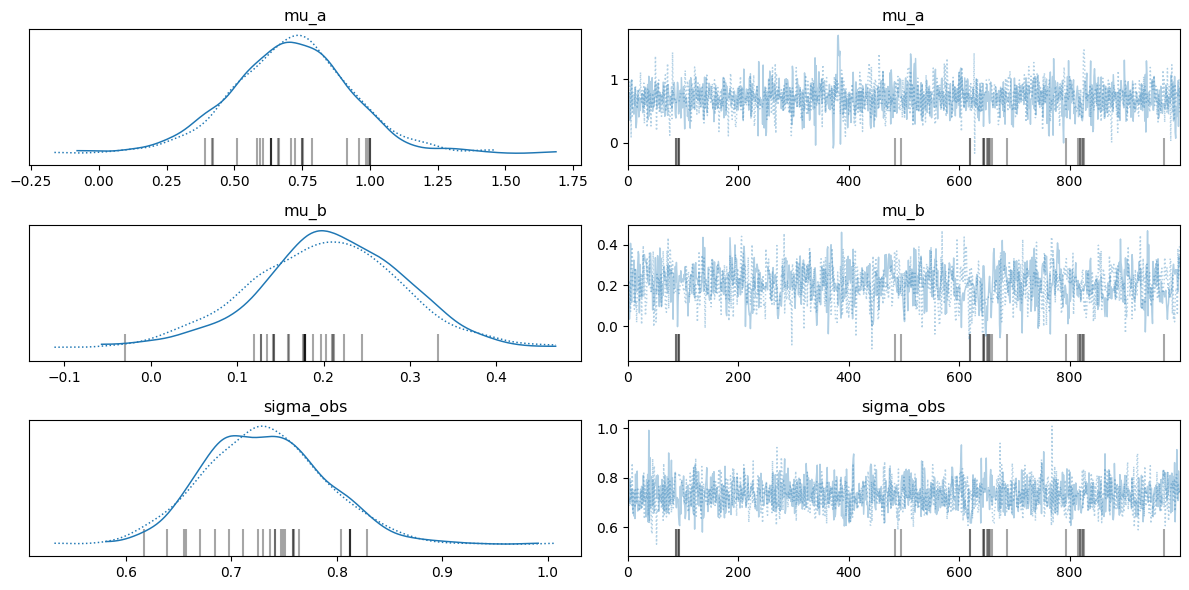

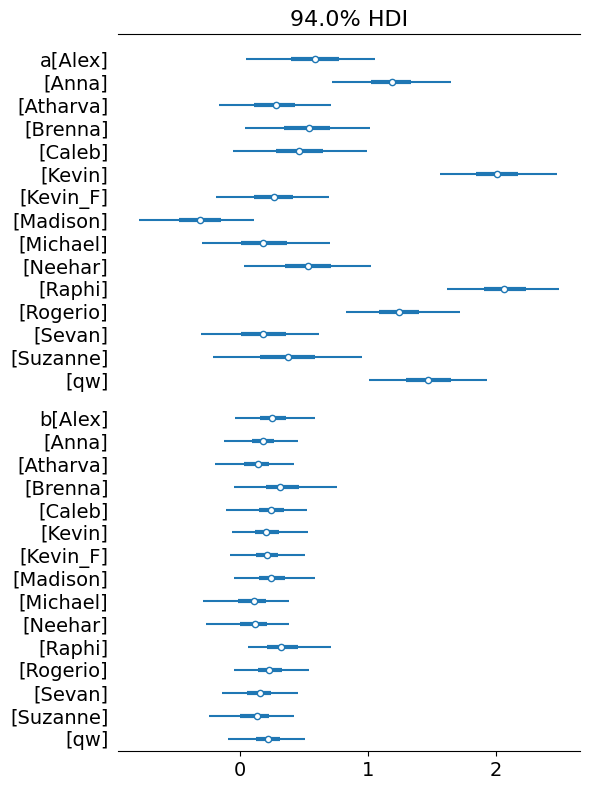

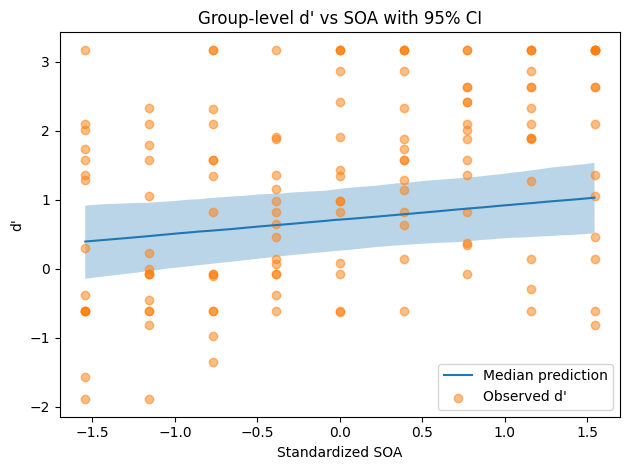

In [13]:
az.plot_trace(trace_metad, var_names=['mu_a', 'mu_b', 'sigma_obs'])
plt.tight_layout()
plt.show()

# 2. Forest plot for subject-level effects
az.plot_forest(trace_metad, var_names=['a', 'b'], combined=True)
plt.tight_layout()
plt.show()

# 3. Group-level regression credible bands
posterior = trace_metad.posterior
mu_a_samples = posterior['mu_a'].stack(samples=("chain", "draw")).values
mu_b_samples = posterior['mu_b'].stack(samples=("chain", "draw")).values

soa_std_vals = np.linspace(d_data['soa_std'].min(), d_data['soa_std'].max(), 50)
preds = np.array([mu_a_samples + mu_b_samples * x for x in soa_std_vals])

median_pred = np.median(preds, axis=1)
lower_pred = np.percentile(preds, 2.5, axis=1)
upper_pred = np.percentile(preds, 97.5, axis=1)

plt.figure()
plt.fill_between(soa_std_vals, lower_pred, upper_pred, alpha=0.3)
plt.plot(soa_std_vals, median_pred, label='Median prediction')
plt.scatter(d_data['soa_std'], d_data['dprime'], alpha=0.5, label="Observed d'")
plt.xlabel('Standardized SOA')
plt.ylabel("d'")
plt.title("Group-level d' vs SOA with 95% CI")
plt.legend()
plt.tight_layout()
plt.show()

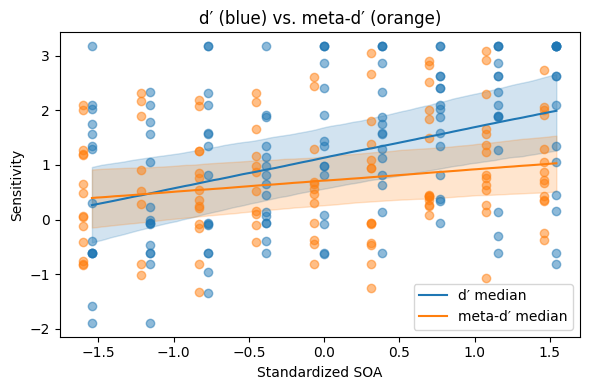

In [14]:
# 1a) Extract posterior samples for both models
post_d  = trace_d.posterior
post_m  = trace_metad.posterior

# stack chains × draws into one axis
a_d_samps = post_d['mu_a'].stack(samps=("chain","draw")).values
b_d_samps = post_d['mu_b'].stack(samps=("chain","draw")).values

a_m_samps = post_m['mu_a'].stack(samps=("chain","draw")).values
b_m_samps = post_m['mu_b'].stack(samps=("chain","draw")).values

# 1b) Make a grid of soa_std
soa_min, soa_max = d_data['soa_std'].min(), d_data['soa_std'].max()
xgrid = np.linspace(soa_min, soa_max, 100)

# 1c) Compute predicted curves
pred_d = np.array([a_d_samps + b_d_samps*x for x in xgrid])  # shape (100, n_samps)
pred_m = np.array([a_m_samps + b_m_samps*x for x in xgrid])

# 1d) Compute medians & 95% CIs
def ci(vals, lower=2.5, upper=97.5):
    return np.percentile(vals, [lower, 50, upper], axis=1)

l_d,   med_d,   u_d   = ci(pred_d)
l_m,   med_m,   u_m   = ci(pred_m)

# 1e) Plot
plt.figure(figsize=(6,4))
# d'
plt.fill_between(xgrid, l_d,   u_d,   color='C0', alpha=0.2)
plt.plot(xgrid,        med_d,  color='C0', label="d′ median")
# meta-d'
plt.fill_between(xgrid, l_m,   u_m,   color='C1', alpha=0.2)
plt.plot(xgrid,        med_m,  color='C1', label="meta-d′ median")

# raw data
plt.scatter(d_data['soa_std'],   d_data['dprime'],      color='C0', alpha=0.5)
plt.scatter(metad_data['soa_std'], metad_data['meta_dprime'], color='C1', alpha=0.5)

plt.xlabel("Standardized SOA")
plt.ylabel("Sensitivity")
plt.legend()
plt.title("d′ (blue) vs. meta-d′ (orange)")
plt.tight_layout()
plt.show()

## Fit Sigmoid Hierarchical Bayesian Models

In [23]:
d_data = summary[['subj', 'soa_offset', 'dprime']].dropna().copy()
d_data['subj_idx'] = d_data['subj'].astype('category').cat.codes
d_data['soa_std'] = (d_data['soa_offset'] - d_data['soa_offset'].mean()) / d_data['soa_offset'].std()
pm.traceplot.progressbar = True

subj_names = d_data['subj'].astype('category').cat.categories.tolist()

n_subj = d_data['subj_idx'].nunique()
soa = d_data['soa_std'].values
si  = d_data['subj_idx'].values
y   = d_data['dprime'].values

with pm.Model() as sigmoid_model:
    # hyperpriors
    L_mu,   L_sigma   = pm.Normal('L_mu',   1, 1), pm.HalfNormal('L_sigma', 1)
    k_mu,   k_sigma   = pm.Normal('k_mu',   1, 1), pm.HalfNormal('k_sigma', 1)
    x0_mu,  x0_sigma  = pm.Normal('x0_mu',  0, 1), pm.HalfNormal('x0_sigma', 1)
    
    # subject-level
    L   = pm.Normal('L',  mu=L_mu,   sigma=L_sigma,   shape=n_subj)
    k   = pm.Normal('k',  mu=k_mu,   sigma=k_sigma,   shape=n_subj)
    x0  = pm.Normal('x0', mu=x0_mu,  sigma=x0_sigma,  shape=n_subj)
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    
    # deterministic predicted mu
    mu = L[si] / (1 + pm.math.exp(-k[si] * (soa - x0[si])))
    
    pm.Normal('obs', mu=mu, sigma=sigma_obs, observed=y)
    
    trace_d_sig = pm.sample(1000, tune=1000, cores=1, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [L_mu, L_sigma, k_mu, k_sigma, x0_mu, x0_sigma, L, k, x0, sigma_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 66 seconds.
There were 257 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


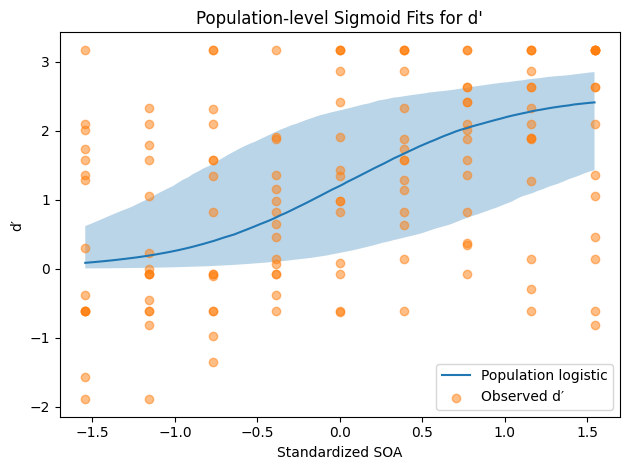

In [24]:
# 1. pull out the hyperparameter chains
L_mu_samps  = trace_d_sig.posterior['L_mu'].stack(samps=("chain","draw")).values
k_mu_samps  = trace_d_sig.posterior['k_mu'].stack(samps=("chain","draw")).values
x0_mu_samps = trace_d_sig.posterior['x0_mu'].stack(samps=("chain","draw")).values

# 2. make your x-grid
xgrid = np.linspace(d_data['soa_std'].min(),
                    d_data['soa_std'].max(), 100)

# 3. compute the logistic for each draw
preds_pop = np.stack([
    L_mu_samps / (1 + np.exp(-k_mu_samps * (x - x0_mu_samps)))
    for x in xgrid
])  # → shape (100, n_draws)

# 4. percentile *across draws* (axis=1 now)
lower_pop, median_pop, upper_pop = np.percentile(preds_pop,
                                                 [2.5, 50, 97.5],
                                                 axis=1)
# each is shape (100,)

# 5. plot
plt.fill_between(xgrid, lower_pop,  upper_pop,  alpha=0.3)
plt.plot        (xgrid, median_pop, label="Population logistic")
plt.scatter     (d_data['soa_std'], d_data['dprime'],
                 alpha=0.5, label="Observed d′")
plt.xlabel('Standardized SOA')
plt.ylabel("d′")
plt.title("Population-level Sigmoid Fits for d'")
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
metad_data = summary[['subj', 'soa_offset', 'meta_dprime']].dropna().copy()
metad_data['subj_idx'] = metad_data['subj'].astype('category').cat.codes
metad_data['soa_std'] = (metad_data['soa_offset'] - metad_data['soa_offset'].mean()) / metad_data['soa_offset'].std()
pm.traceplot.progressbar = True

subj_names = metad_data['subj'].astype('category').cat.categories.tolist()

n_subj = metad_data['subj_idx'].nunique()
soa = metad_data['soa_std'].values
si  = metad_data['subj_idx'].values
y   = metad_data['meta_dprime'].values

with pm.Model() as sigmoid_model:
    # hyperpriors
    L_mu,   L_sigma   = pm.Normal('L_mu',   1, 1), pm.HalfNormal('L_sigma', 1)
    k_mu,   k_sigma   = pm.Normal('k_mu',   1, 1), pm.HalfNormal('k_sigma', 1)
    x0_mu,  x0_sigma  = pm.Normal('x0_mu',  0, 1), pm.HalfNormal('x0_sigma', 1)
    
    # subject-level
    L   = pm.Normal('L',  mu=L_mu,   sigma=L_sigma,   shape=n_subj)
    k   = pm.Normal('k',  mu=k_mu,   sigma=k_sigma,   shape=n_subj)
    x0  = pm.Normal('x0', mu=x0_mu,  sigma=x0_sigma,  shape=n_subj)
    
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    
    # deterministic predicted mu
    mu = L[si] / (1 + pm.math.exp(-k[si] * (soa - x0[si])))
    
    pm.Normal('obs', mu=mu, sigma=sigma_obs, observed=y)
    
    trace_metad_sig = pm.sample(1000, tune=1000, cores=1, chains=4, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [L_mu, L_sigma, k_mu, k_sigma, x0_mu, x0_sigma, L, k, x0, sigma_obs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 1266 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


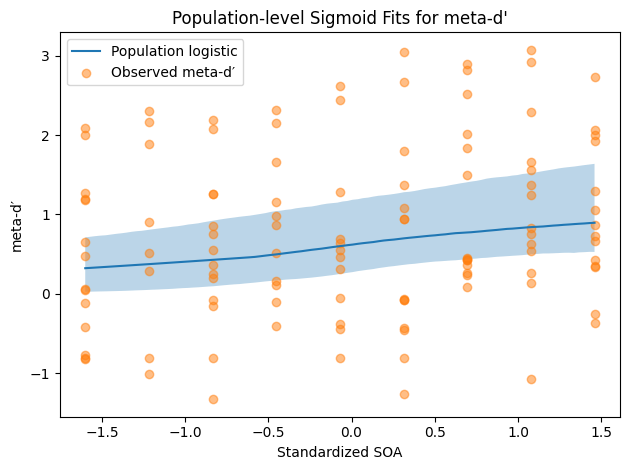

In [26]:
# 1. pull out the hyperparameter chains
L_mu_samps  = trace_metad_sig.posterior['L_mu'].stack(samps=("chain","draw")).values
k_mu_samps  = trace_metad_sig.posterior['k_mu'].stack(samps=("chain","draw")).values
x0_mu_samps = trace_metad_sig.posterior['x0_mu'].stack(samps=("chain","draw")).values

# 2. make your x-grid
xgrid = np.linspace(metad_data['soa_std'].min(),
                    metad_data['soa_std'].max(), 100)

# 3. compute the logistic for each draw
preds_pop = np.stack([
    L_mu_samps / (1 + np.exp(-k_mu_samps * (x - x0_mu_samps)))
    for x in xgrid
])  # → shape (100, n_draws)

# 4. percentile *across draws* (axis=1 now)
lower_pop, median_pop, upper_pop = np.percentile(preds_pop,
                                                 [2.5, 50, 97.5],
                                                 axis=1)
# each is shape (100,)

# 5. plot
plt.fill_between(xgrid, lower_pop,  upper_pop,  alpha=0.3)
plt.plot        (xgrid, median_pop, label="Population logistic")
plt.scatter     (metad_data['soa_std'], metad_data['meta_dprime'],
                 alpha=0.5, label="Observed meta-d′")
plt.xlabel('Standardized SOA')
plt.ylabel("meta-d′")
plt.title("Population-level Sigmoid Fits for meta-d'")
plt.legend()
plt.tight_layout()
plt.show()

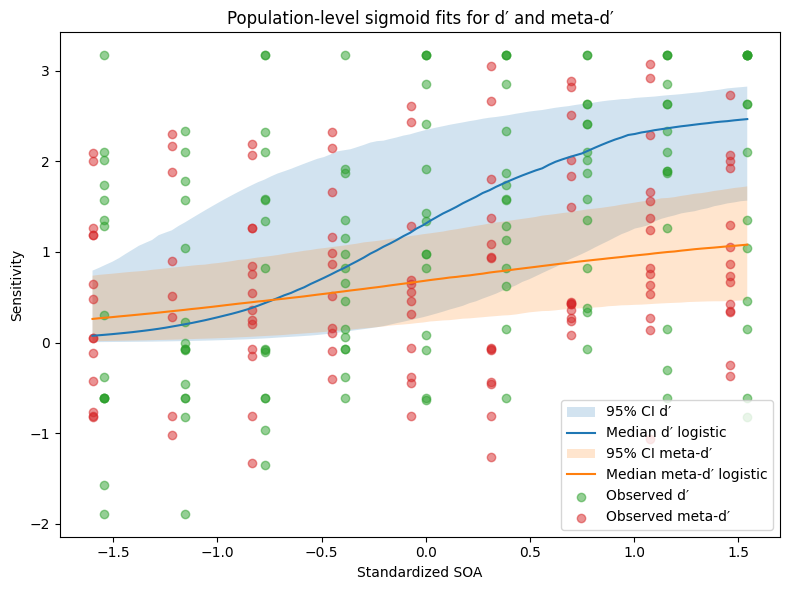

In [16]:
all_min = min(d_data['soa_std'].min(),
              metad_data['soa_std'].min())
all_max = max(d_data['soa_std'].max(),
              metad_data['soa_std'].max())
xgrid   = np.linspace(all_min, all_max, 100)

# 2) (Re)compute your pop-level bands if needed...
#    (example for d′ — do the same for meta-d′)
L_mu_d   = trace_d_sig.posterior['L_mu'].stack(samps=("chain","draw")).values
k_mu_d   = trace_d_sig.posterior['k_mu'].stack(samps=("chain","draw")).values
x0_mu_d  = trace_d_sig.posterior['x0_mu'].stack(samps=("chain","draw")).values

preds_d_pop = np.stack([
    L_mu_d / (1 + np.exp(-k_mu_d * (x - x0_mu_d)))
    for x in xgrid
])  # → (100, n_draws)

lower_d, median_d, upper_d = np.percentile(preds_d_pop,
                                           [2.5, 50, 97.5],
                                           axis=1)

# …and similarly for meta-d′:
L_mu_m   = trace_metad_sig.posterior['L_mu'].stack(samps=("chain","draw")).values
k_mu_m   = trace_metad_sig.posterior['k_mu'].stack(samps=("chain","draw")).values
x0_mu_m  = trace_metad_sig.posterior['x0_mu'].stack(samps=("chain","draw")).values

preds_m_pop = np.stack([
    L_mu_m / (1 + np.exp(-k_mu_m * (x - x0_mu_m)))
    for x in xgrid
])
lower_m, median_m, upper_m = np.percentile(preds_m_pop,
                                           [2.5, 50, 97.5],
                                           axis=1)
# 3) Plot them together
plt.figure(figsize=(8,6))

# d′ band + median
plt.fill_between(xgrid, lower_d, upper_d,
                 alpha=0.2, label="95% CI d′")
plt.plot        (xgrid, median_d,
                 label="Median d′ logistic")

# meta-d′ band + median
plt.fill_between(xgrid, lower_m, upper_m,
                 alpha=0.2, label="95% CI meta-d′")
plt.plot        (xgrid, median_m,
                 label="Median meta-d′ logistic")

# raw points
plt.scatter(d_data['soa_std'],      d_data['dprime'],
            alpha=0.5, label="Observed d′")
plt.scatter(metad_data['soa_std'],  metad_data['meta_dprime'],
            alpha=0.5, label="Observed meta-d′")

plt.xlabel("Standardized SOA")
plt.ylabel("Sensitivity")
plt.title("Population-level sigmoid fits for d′ and meta-d′")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

## Fit a Joint Hierarchical Linear Bayesian Model

In [ ]:
n_subj = d_data['subj_idx'].nunique()

soa_d = d_data['soa_std'].values
si_d  = d_data['subj_idx'].values
y_d   = d_data['dprime'].values

soa_m = metad_data['soa_std'].values
si_m  = metad_data['subj_idx'].values
y_m   = metad_data['meta_dprime'].values

with pm.Model() as joint_model:
    # -- hyper: intercepts --
    mu_a = pm.Normal('mu_a', 0, 1, shape=2)             # [μ_ad, μ_am]
    sd_a = pm.HalfNormal('sd_a', 1, shape=2)
    rho_a = pm.LKJCholeskyCov('rho_a', n=2, eta=2, sd_dist=pm.HalfNormal.dist(1.0), compute_corr=False)
    chol_a = pm.expand_packed_triangular(2, rho_a, lower=True)
    
    # -- hyper: slopes --
    mu_b = pm.Normal('mu_b', 0, 1, shape=2)             # [μ_bd, μ_bm]
    sd_b = pm.HalfNormal('sd_b', 1, shape=2)
    rho_b = pm.LKJCholeskyCov('rho_b', n=2, eta=2, sd_dist=pm.HalfNormal.dist(1.0), compute_corr=False)
    chol_b = pm.expand_packed_triangular(2, rho_b, lower=True)
    
    # subject-level joint intercepts & slopes
    a = pm.MvNormal('a', mu=mu_a, chol=chol_a, shape=(n_subj, 2))
    b = pm.MvNormal('b', mu=mu_b, chol=chol_b, shape=(n_subj, 2))
    
    # observation noise
    sigma_d = pm.HalfNormal('sigma_d', 1)
    sigma_m = pm.HalfNormal('sigma_m', 1)
    
    # predicted means
    mu_d = a[si_d, 0] + b[si_d, 0] * soa_d
    mu_m = a[si_m, 1] + b[si_m, 1] * soa_m
    
    # likelihoods
    pm.Normal('obs_d', mu=mu_d, sigma=sigma_d, observed=y_d)
    pm.Normal('obs_m', mu=mu_m, sigma=sigma_m, observed=y_m)
    
    trace_joint = pm.sample(1000, tune=1000, chains=4, cores=1, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [mu_a, sd_a, rho_a, mu_b, sd_b, rho_b, a, b, sigma_d, sigma_m]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 84 seconds.
There were 104 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


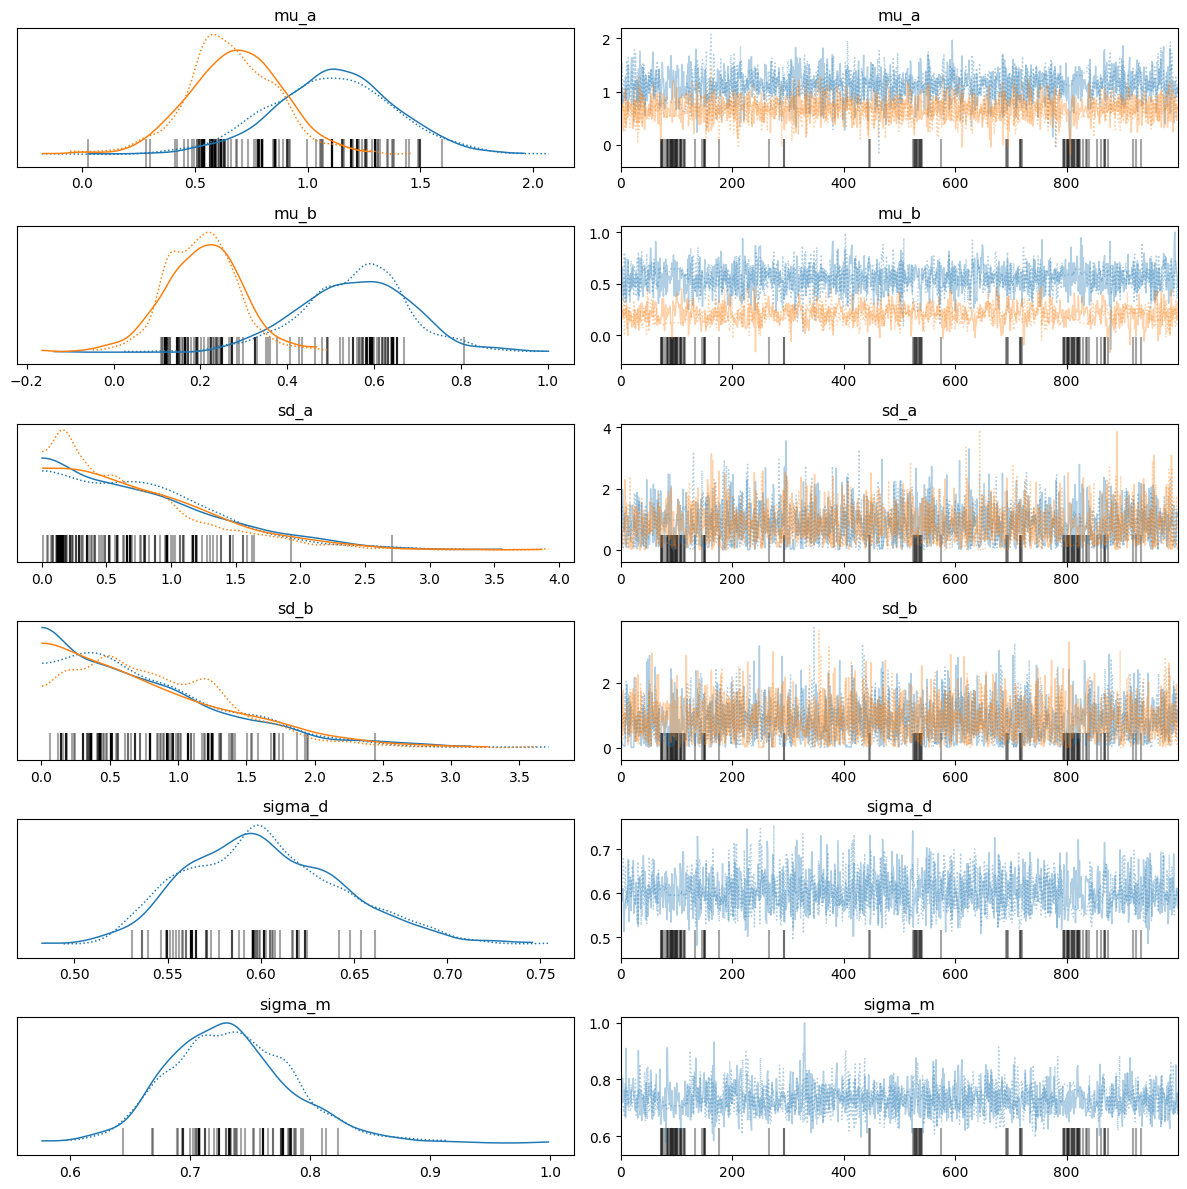

In [21]:
az.plot_trace(
    trace_joint,
    var_names=["mu_a", "mu_b", "sd_a", "sd_b", "sigma_d", "sigma_m"]
)
plt.tight_layout()
plt.show()

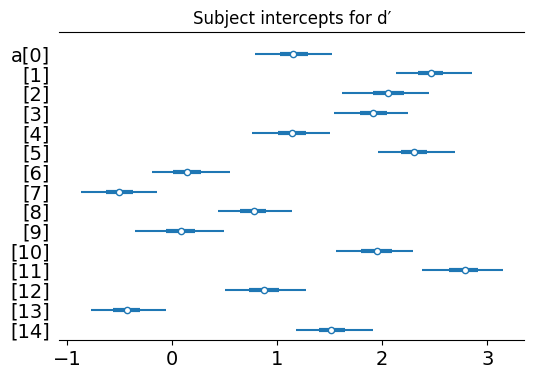

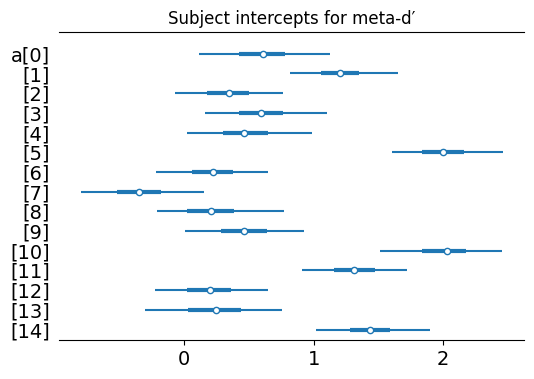

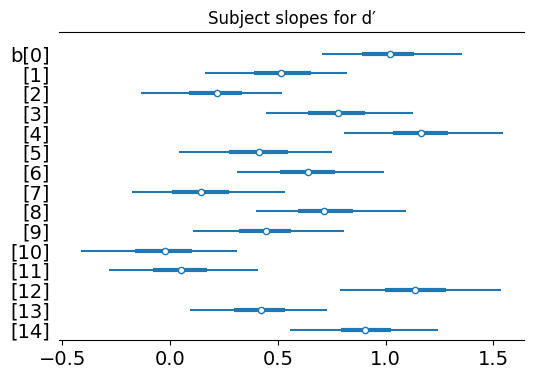

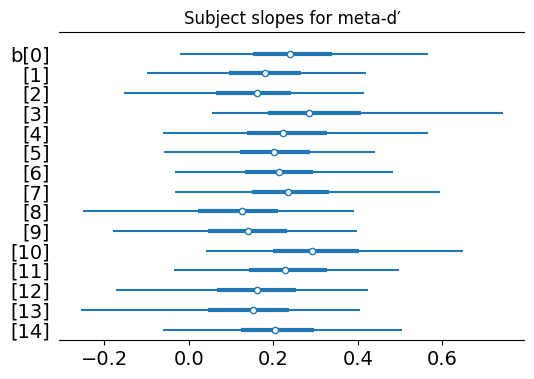

In [22]:
az.plot_forest(
    trace_joint,
    var_names=["a"],
    combined=True,
    coords={"a_dim_1": [0]},
    figsize=(6,4)
)
plt.title("Subject intercepts for d′")
plt.show()

# intercepts for meta-d′ (a[:,1])
az.plot_forest(
    trace_joint,
    var_names=["a"],
    combined=True,
    coords={"a_dim_1": [1]},
    figsize=(6,4)
)
plt.title("Subject intercepts for meta-d′")
plt.show()

# slopes for d′ (b[:,0])
az.plot_forest(
    trace_joint,
    var_names=["b"],
    combined=True,
    coords={"b_dim_1": [0]},
    figsize=(6,4)
)
plt.title("Subject slopes for d′")
plt.show()

# slopes for meta-d′ (b[:,1])
az.plot_forest(
    trace_joint,
    var_names=["b"],
    combined=True,
    coords={"b_dim_1": [1]},
    figsize=(6,4)
)
plt.title("Subject slopes for meta-d′")
plt.show()

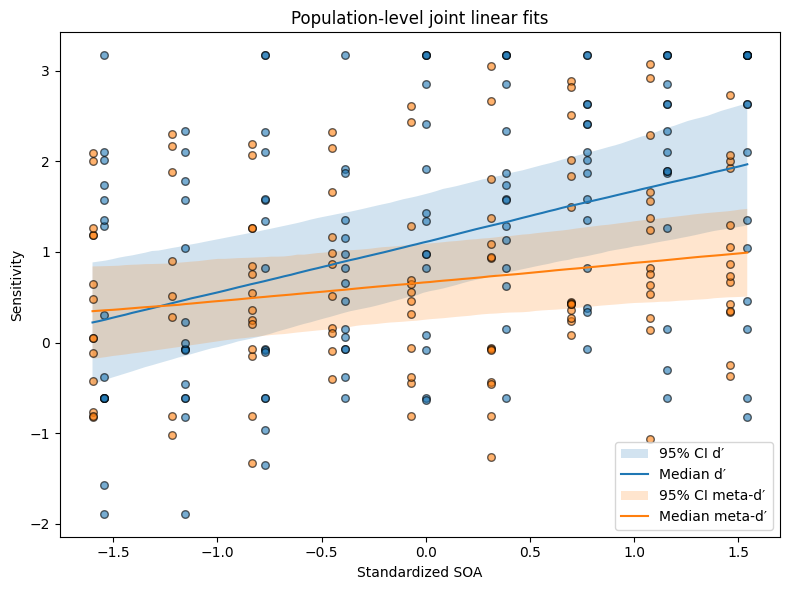

In [23]:
min_x = min(d_data['soa_std'].min(),
            metad_data['soa_std'].min())
max_x = max(d_data['soa_std'].max(),
            metad_data['soa_std'].max())
xgrid = np.linspace(min_x, max_x, 100)

# b) stack hyper samples
ma = trace_joint.posterior["mu_a"].stack(samps=("chain","draw")).values  # shape (2, N)
mb = trace_joint.posterior["mu_b"].stack(samps=("chain","draw")).values  # shape (2, N)

# c) compute predicted y for each draw
pred_d = np.stack([ma[0] + mb[0] * x for x in xgrid])  # → (100, N)
pred_m = np.stack([ma[1] + mb[1] * x for x in xgrid])  # → (100, N)

# d) credible intervals
l_d, m_d, u_d = np.percentile(pred_d, [2.5,50,97.5], axis=1)
l_m, m_m, u_m = np.percentile(pred_m, [2.5,50,97.5], axis=1)

# e) plot
plt.figure(figsize=(8,6))

plt.fill_between(xgrid, l_d, u_d, alpha=0.2,  label="95% CI d′")
plt.plot        (xgrid, m_d,     color='C0', label="Median d′")

plt.fill_between(xgrid, l_m, u_m, alpha=0.2,  label="95% CI meta-d′")
plt.plot        (xgrid, m_m,     color='C1', label="Median meta-d′")

plt.scatter(d_data['soa_std'],      d_data['dprime'],
            color='C0', edgecolor='k', alpha=0.6, s=30)
plt.scatter(metad_data['soa_std'],  metad_data['meta_dprime'],
            color='C1', edgecolor='k', alpha=0.6, s=30)

plt.xlabel("Standardized SOA")
plt.ylabel("Sensitivity")
plt.title ("Population‐level joint linear fits")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Fit a Joint Hierarchical **Sigmoid** Bayesian Model

In [17]:
n_subj = d_data['subj_idx'].nunique()

soa_d = d_data['soa_std'].values
si_d  = d_data['subj_idx'].values
y_d   = d_data['dprime'].values

soa_m = metad_data['soa_std'].values
si_m  = metad_data['subj_idx'].values
y_m   = metad_data['meta_dprime'].values

with pm.Model() as joint_sigmoid_model:
    # 1) Hyperpriors for the three sigmoid parameters, each with 2 outcomes (d′ vs meta-d′)
    #    a) Height L
    mu_L   = pm.Normal ('mu_L',   mu=1, sigma=1, shape=2)
    sd_L   = pm.HalfNormal('sd_L', sigma=1, shape=2)
    packed_L = pm.LKJCholeskyCov(
        "packed_L", n=2, eta=2,
        sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=False
    )
    chol_L = pm.expand_packed_triangular(2, packed_L, lower=True)

    #    b) Slope k
    mu_k   = pm.Normal ('mu_k',   mu=1, sigma=1, shape=2)
    sd_k   = pm.HalfNormal('sd_k', sigma=1, shape=2)
    packed_k = pm.LKJCholeskyCov(
        "packed_k", n=2, eta=2,
        sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=False
    )
    chol_k = pm.expand_packed_triangular(2, packed_k, lower=True)

    #    c) Midpoint x0
    mu_x0  = pm.Normal ('mu_x0',  mu=0, sigma=1, shape=2)
    sd_x0  = pm.HalfNormal('sd_x0',sigma=1, shape=2)
    packed_x0 = pm.LKJCholeskyCov(
        "packed_x0", n=2, eta=2,
        sd_dist=pm.HalfNormal.dist(1.0),
        compute_corr=False
    )
    chol_x0 = pm.expand_packed_triangular(2, packed_x0, lower=True)

    # 2) Subject-level parameters: shape=(n_subj, 2) so [:,0]=d′, [:,1]=meta-d′
    L  = pm.MvNormal('L',  mu=mu_L,  chol=chol_L,  shape=(n_subj,2))
    k  = pm.MvNormal('k',  mu=mu_k,  chol=chol_k,  shape=(n_subj,2))
    x0 = pm.MvNormal('x0', mu=mu_x0, chol=chol_x0, shape=(n_subj,2))

    # 3) Observation noise
    sigma_d = pm.HalfNormal('sigma_d', sigma=1)
    sigma_m = pm.HalfNormal('sigma_m', sigma=1)

    # 4) Sigmoid predictions
    mu_d = L[si_d, 0] / (1 + pm.math.exp(-k[si_d, 0] * (soa_d - x0[si_d, 0])))
    mu_m = L[si_m, 1] / (1 + pm.math.exp(-k[si_m, 1] * (soa_m - x0[si_m, 1])))

    # 5) Likelihoods
    pm.Normal('obs_d', mu=mu_d, sigma=sigma_d, observed=y_d)
    pm.Normal('obs_m', mu=mu_m, sigma=sigma_m, observed=y_m)

    # 6) Sample
    trace_joint_sig = pm.sample(
        1000, tune=1000,
        chains=4, cores=1,
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [mu_L, sd_L, packed_L, mu_k, sd_k, packed_k, mu_x0, sd_x0, packed_x0, L, k, x0, sigma_d, sigma_m]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 689 seconds.
There were 210 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


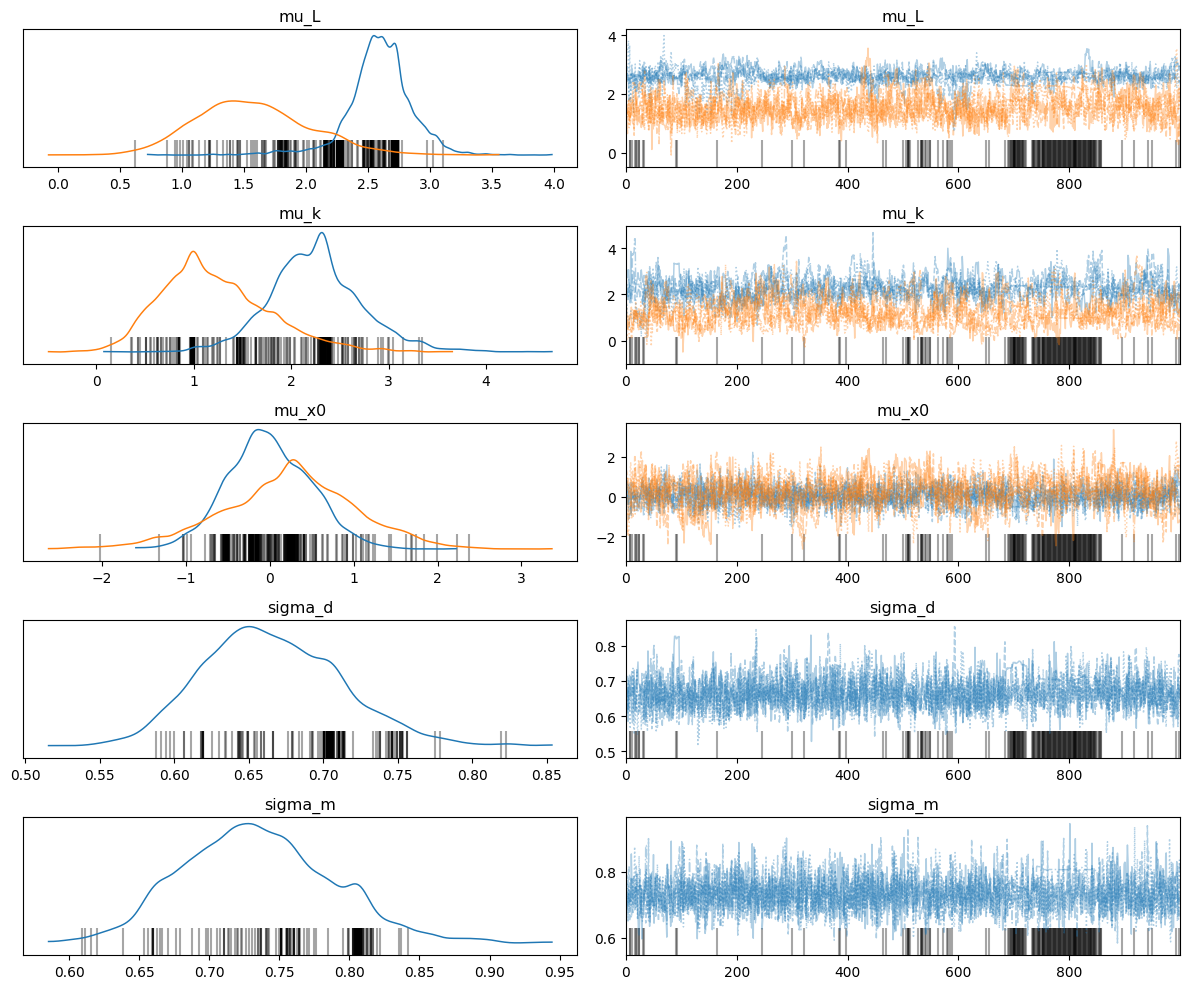

In [18]:
az.plot_trace(
    trace_joint_sig,
    var_names=["mu_L","mu_k","mu_x0","sigma_d","sigma_m"],
    combined=True
)
plt.tight_layout()
plt.show()

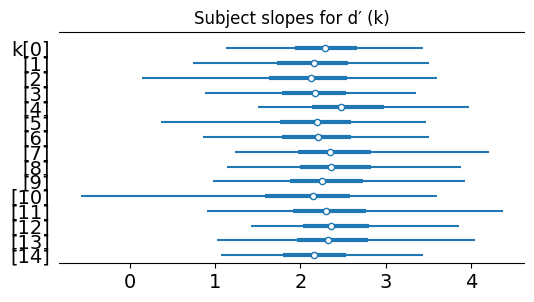

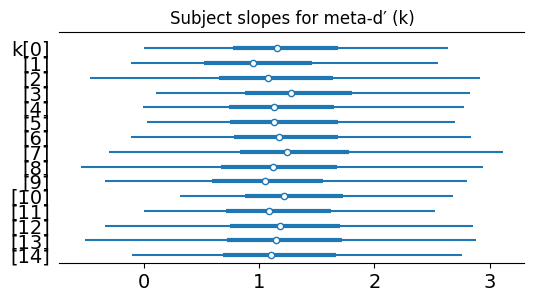

In [19]:
# slopes for d′: k[:,0]
az.plot_forest(
    trace_joint_sig,
    var_names=["k"],
    coords={"k_dim_1": [0]},     # index 0 = d′
    combined=True,
    figsize=(6,3)
)
plt.title("Subject slopes for d′ (k)")
plt.show()

# slopes for meta-d′: k[:,1]
az.plot_forest(
    trace_joint_sig,
    var_names=["k"],
    coords={"k_dim_1": [1]},     # index 1 = meta-d′
    combined=True,
    figsize=(6,3)
)
plt.title("Subject slopes for meta-d′ (k)")
plt.show()

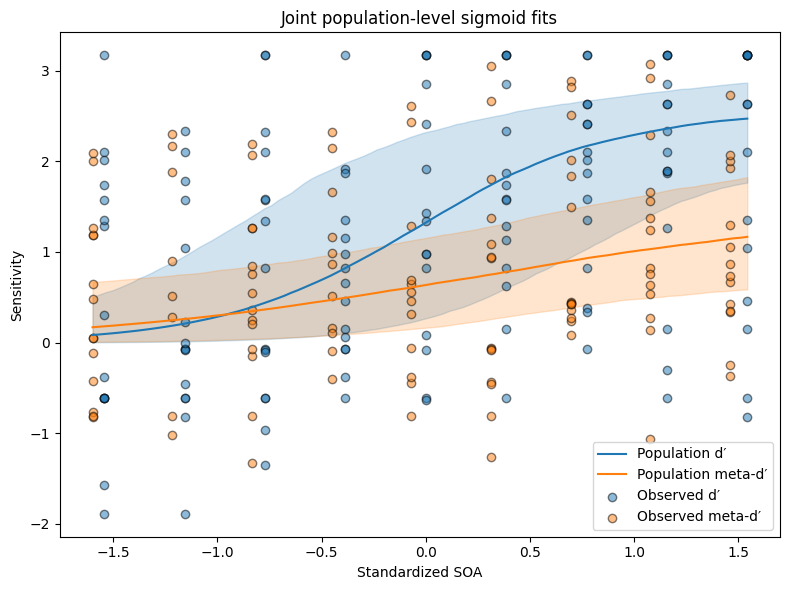

In [20]:
# 1) unified x-grid
all_min = min(d_data['soa_std'].min(),
              metad_data['soa_std'].min())
all_max = max(d_data['soa_std'].max(),
              metad_data['soa_std'].max())
xgrid   = np.linspace(all_min, all_max, 100)

# 2) stack hyperparameter chains
# shape (2, n_samples): row0=d′, row1=meta-d′
L_mu_samps  = trace_joint_sig.posterior["mu_L"].stack(samps=("chain","draw")).values
k_mu_samps  = trace_joint_sig.posterior["mu_k"].stack(samps=("chain","draw")).values
x0_mu_samps = trace_joint_sig.posterior["mu_x0"].stack(samps=("chain","draw")).values

# 3) logistic predictions for each draw
preds_d = np.stack([
    L_mu_samps[0] / (1 + np.exp(-k_mu_samps[0] * (x - x0_mu_samps[0])))
    for x in xgrid
])  # → (100, n_samples)
preds_m = np.stack([
    L_mu_samps[1] / (1 + np.exp(-k_mu_samps[1] * (x - x0_mu_samps[1])))
    for x in xgrid
])

# 4) 2.5 / 50 / 97.5 percentiles along the sample-axis (axis=1)
lower_d, median_d, upper_d = np.percentile(preds_d, [2.5, 50, 97.5], axis=1)
lower_m, median_m, upper_m = np.percentile(preds_m, [2.5, 50, 97.5], axis=1)

# 5) plot
plt.figure(figsize=(8,6))

# d′ band + median
plt.fill_between(xgrid, lower_d, upper_d, color="C0", alpha=0.2)
plt.plot        (xgrid, median_d, color="C0", label="Population d′")

# meta-d′ band + median
plt.fill_between(xgrid, lower_m, upper_m, color="C1", alpha=0.2)
plt.plot        (xgrid, median_m, color="C1", label="Population meta-d′")

# raw data
plt.scatter(d_data['soa_std'],      d_data['dprime'],
            edgecolor='k', alpha=0.5, color="C0", label="Observed d′")
plt.scatter(metad_data['soa_std'],  metad_data['meta_dprime'],
            edgecolor='k', alpha=0.5, color="C1", label="Observed meta-d′")

plt.xlabel("Standardized SOA")
plt.ylabel("Sensitivity")
plt.title ("Joint population‐level sigmoid fits")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

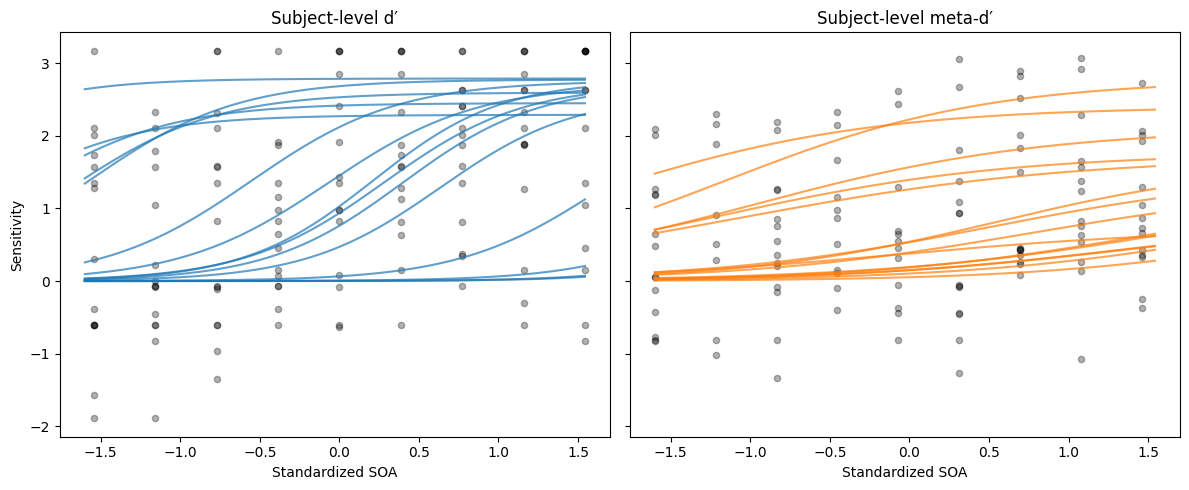

In [21]:
# 1) Build x-grid
all_min = min(d_data['soa_std'].min(), metad_data['soa_std'].min())
all_max = max(d_data['soa_std'].max(), metad_data['soa_std'].max())
xgrid   = np.linspace(all_min, all_max, 200)

# 2) Extract & stack posterior samples
L_samps  = trace_joint_sig.posterior['L'].stack(sample=("chain","draw")).values
k_samps  = trace_joint_sig.posterior['k'].stack(sample=("chain","draw")).values
x0_samps = trace_joint_sig.posterior['x0'].stack(sample=("chain","draw")).values
# shapes: (n_subj, 2, n_samples)

# 3) Median per subject & outcome
L_med  = np.median(L_samps,  axis=2)   # (n_subj, 2)
k_med  = np.median(k_samps,  axis=2)
x0_med = np.median(x0_samps, axis=2)

# 4) Set up subplots
fig, axs = plt.subplots(1,2, figsize=(12,5), sharey=True)
outcomes = ['d′','meta-d′']
colors   = ['C0','C1']

for j in [0,1]:
    ax = axs[j]
    for i, subj in enumerate(subj_names):
        Li, ki, x0i = L_med[i,j], k_med[i,j], x0_med[i,j]
        yi = Li / (1 + np.exp(-ki * (xgrid - x0i)))
        ax.plot(xgrid, yi, color=colors[j], alpha=0.7, lw=1.5)
    # scatter raw data
    data_y = d_data['dprime']      if j==0 else metad_data['meta_dprime']
    data_x = d_data['soa_std']     if j==0 else metad_data['soa_std']
    ax.scatter(data_x, data_y, color='k', s=20, alpha=0.3)
    
    ax.set_title(f"Subject-level {outcomes[j]}")
    ax.set_xlabel("Standardized SOA")
axs[0].set_ylabel("Sensitivity")
plt.tight_layout()
plt.show()

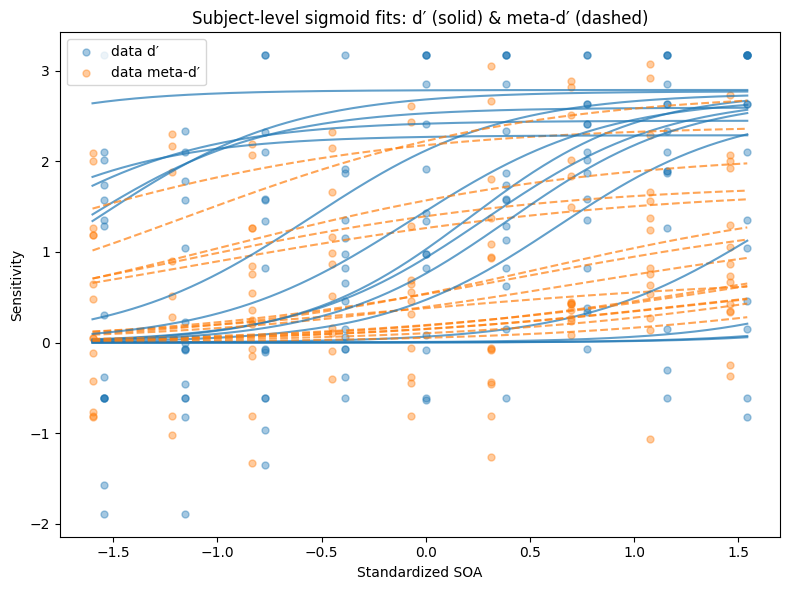

In [22]:
plt.figure(figsize=(8,6))

for i, subj in enumerate(subj_names):
    # d′ (solid C0)
    Li, ki, x0i = L_med[i,0], k_med[i,0], x0_med[i,0]
    yi = Li / (1 + np.exp(-ki * (xgrid - x0i)))
    plt.plot(xgrid, yi, color='C0', alpha=0.7, lw=1.5)
    # meta-d′ (dashed C1)
    Li2, ki2, x0i2 = L_med[i,1], k_med[i,1], x0_med[i,1]
    yi2 = Li2 / (1 + np.exp(-ki2 * (xgrid - x0i2)))
    plt.plot(xgrid, yi2, color='C1', alpha=0.7, lw=1.5, linestyle='--')

# raw data
plt.scatter(d_data['soa_std'],     d_data['dprime'],
            color='C0', s=25, alpha=0.4, label="data d′")
plt.scatter(metad_data['soa_std'], metad_data['meta_dprime'],
            color='C1', s=25, alpha=0.4, label="data meta-d′")

plt.xlabel("Standardized SOA")
plt.ylabel("Sensitivity")
plt.title("Subject-level sigmoid fits: d′ (solid) & meta-d′ (dashed)")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()